In [1]:
%%time
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

CPU times: user 47 µs, sys: 25 µs, total: 72 µs
Wall time: 75.6 µs


In [2]:
%%time
### 生成输出目录的模块
import os
from datetime import datetime

def generate_output(random_disturb: bool, filename):
    slurm_job_id = os.environ.get('SLURM_JOB_ID')
    # Generate the folder name with the current date
    now = datetime.now()
    if random_disturb:
        folder_name = f"{slurm_job_id}_Graph_Rmv_Stoch_{now.strftime('%Y-%m-%d-%H-%M')}"
    else:
        folder_name = f"{slurm_job_id}_Graph_Rmv_Btwn_{now.strftime('%Y-%m-%d-%H-%M')}"

    # Create the output directory if it doesn't exist
    output_dir = os.path.join(os.getcwd(), folder_name)
    os.makedirs(output_dir, exist_ok=True)

    # Construct the full file path
    file_path = os.path.join(output_dir, filename)

    return file_path

CPU times: user 7 µs, sys: 3 µs, total: 10 µs
Wall time: 12.9 µs


In [3]:
%%time
### 生成删除顶点的顺序 模块
import random
import networkx as nx
import numpy as np

def nodes_sample(random_disturb: bool, graph, number_of_nodes: int, percent, betweenness):
    graph_copy = graph.copy()
    sample_size = int(number_of_nodes * percent)
    if random_disturb:
        removed_nodes = random.sample(range(number_of_nodes), sample_size)
        graph_copy.remove_nodes_from(removed_nodes)
        if nx.is_connected(graph_copy):
            return removed_nodes
    else: 
        removed_nodes = random.choices(range(number_of_nodes), betweenness, k=sample_size)
        graph_copy.remove_nodes_from(removed_nodes)
        if nx.is_connected(graph_copy):
            return removed_nodes
        

import numpy as np
import json

def generate_remove_list(random_disturb: bool, graph, number_of_nodes, betweenness):
    remove_procedure = []
    for percent in np.arange(0.05, 0.86, 0.05):
        ls = []
        while len(ls) < 10:
            temp = nodes_sample(random_disturb=random_disturb, graph=graph, number_of_nodes=number_of_nodes, percent=percent, betweenness=betweenness)
            if temp is not None:
                ls.append(temp)
        remove_procedure.append(ls)
    filename = generate_output(random_disturb, "0Remove_Procedure.txt")
    with open(filename, 'w') as file:
        json.dump(remove_procedure, file)
    return remove_procedure


import numpy as np

def remove_procedure_index(remove_procedure, num_nodes):
    index = []
    for sublist_list in remove_procedure:
        sublist_index = []
        for sublist in sublist_list:
            temp = np.ones(num_nodes, dtype=bool)
            temp[sublist] = False
            sublist_index.append(temp)
        index.append(sublist_index)
    return index

CPU times: user 1.79 s, sys: 7.1 s, total: 8.89 s
Wall time: 2.89 s


In [4]:
%%time

import csv

def save_scores_to_csv(random_disturb: bool, scores, filename):
    """
    Saves a list of list of list to a CSV file with a double space separator.

    Args:
        scores (list): The list of list of list to be saved.
        disturb (bool): A boolean indicating if disturbance is present.
        filename (str): The name of the output CSV file.
    """
    # Construct the full file path
    file_path = generate_output(random_disturb, filename + ".csv")

    with open(file_path, 'a', newline='') as file:
        writer = csv.writer(file, delimiter=' ')
        for line in scores:
            writer.writerow(line)
            file.write('\n')
        file.write('----------------------------------------\n')
        

CPU times: user 349 µs, sys: 1.16 ms, total: 1.51 ms
Wall time: 2.43 ms


In [5]:
%%time
import os
import csv
from datetime import date

def save_to_csv(random_disturb: bool, content, filename):
    """
    Saves a list of 4-lists to a CSV file with a double space separator.
    
    Args:
        scores (list): The list of 4-lists to be saved.
        filename (str): The name of the output CSV file.
    """
    # Construct the full file path
    file_path = generate_output(random_disturb, filename+".csv")

    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file, delimiter=' ')
        for content_list in content:
            writer.writerow(content_list)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 9.78 µs


In [6]:
%%time
def Plot_Separate(output:bool, random_disturb:bool, MEAN, STD, filename):
    # Generate x-coordinates for the data points with a step size of 0.05
    x_values = np.arange(0.05, 0.86, 0.05)

    # Create a figure with four subplots
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True)

    # Plot the lines for columns 1 in the first subplot
    ax1.plot(x_values, [MEAN[i][0] for i in range(len(MEAN))], label='Eucl & NMI', color='tab:red')
    ax1.fill_between(x_values, np.subtract([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]),
                     np.add([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]), alpha=0.2, color='tab:red')
    ax1.set_ylabel('NMI')
    ax1.legend()

    # Plot the lines for columns 2 in the second subplot
    ax2.plot(x_values, [MEAN[i][1] for i in range(len(MEAN))], label='Cosn & NMI', color='tab:green')
    ax2.fill_between(x_values, np.subtract([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]),
                     np.add([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]), alpha=0.2, color='tab:green')
    ax2.set_ylabel('NMI')
    ax2.legend()

    # Plot the lines for columns 3 in the third subplot
    ax3.plot(x_values, [MEAN[i][2] for i in range(len(MEAN))], label='Eucl & ECSim', color='tab:blue')
    ax3.fill_between(x_values, np.subtract([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]),
                     np.add([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]), alpha=0.2, color='tab:blue')
    ax3.set_ylabel('ECSim')
    ax3.legend()
    
    # Plot the lines for columns 4 in the fourth subplot
    ax4.plot(x_values, [MEAN[i][3] for i in range(len(MEAN))], label='Cosn & ECSim', color='tab:orange')
    ax4.fill_between(x_values, np.subtract([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]),
                     np.add([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]), alpha=0.2, color='tab:orange')
    ax4.set_xlabel('Percentage of Nodes Removed')
    ax4.set_ylabel('ECSim')

    # Remove the legend for "Column 4" in the fourth subplot
    #ax4.legend(handles=ax4.lines[:-1])

    # Set the x-axis scale
    plt.xticks(np.arange(0.0, 0.9, 0.05))

    # Automatically determine the lower bound for the y-axis
    y_min = min([min(y) for y in MEAN])
    y_max = max([max(y) for y in MEAN])
    y_range = y_max - y_min
    y_offset = y_range * 0.1  # Adjust the offset as needed
    y_lower = y_min - y_offset - 0.01
    y_upper = 1.02
    ax1.set_ylim(y_lower, y_upper)
    ax2.set_ylim(y_lower, y_upper)
    ax3.set_ylim(y_lower, y_upper)
    ax4.set_ylim(y_lower, y_upper)

    # Set the y-axis tick marks
    y_tick_step = 0.025
    y_ticks = np.arange(np.ceil(y_lower * 10) / 10, y_upper + 0.5*y_tick_step, y_tick_step)
    # Add horizontal reference lines
    for y in y_ticks:
        ax1.axhline(y=y, color='gray', linestyle='--', alpha=0.3)
        ax2.axhline(y=y, color='gray', linestyle='--', alpha=0.3)
        ax3.axhline(y=y, color='gray', linestyle='--', alpha=0.3)
        ax4.axhline(y=y, color='gray', linestyle='--', alpha=0.3)

    ax1.set_yticks(y_ticks)
    ax2.set_yticks(y_ticks)
    ax3.set_yticks(y_ticks)
    ax4.set_yticks(y_ticks)

    # Adjust the figure size
    fig.set_size_inches(10, 20)  # Increase the height of the figure
    fig.suptitle('Separate Plots',y=0.92)
    
    if output:
        filename = filename+"_SEPARATE"

        file_path = generate_output(random_disturb, filename+".png")
        plt.savefig(file_path)    

    # Show the plot
    plt.show()

CPU times: user 1e+03 ns, sys: 3 µs, total: 4 µs
Wall time: 6.2 µs


In [7]:
%%time
import numpy as np
import matplotlib.pyplot as plt

def Plot_Combine(output:bool, random_disturb:bool, MEAN, STD, filename):
    # Generate x-coordinates for the data points with a step size of 0.05
    x_values = np.arange(0.05, 0.86, 0.05)

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    # Plot the lines for columns 1 and 3 in the first subplot
    ax1.plot(x_values, [MEAN[i][0] for i in range(len(MEAN))], label='Eucl & NMI', color='tab:red')
    ax1.plot(x_values, [MEAN[i][2] for i in range(len(MEAN))], label='Eucl & ECSim', color='tab:blue')
    ax1.fill_between(x_values, np.subtract([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]),
                     np.add([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]), alpha=0.2, color='tab:red')
    ax1.fill_between(x_values, np.subtract([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]),
                     np.add([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]), alpha=0.2, color='tab:blue')
    ax1.set_ylabel('NMI&ECSim')
    ax1.legend()

    # Plot the lines for columns 2 and 4 in the second subplot
    ax2.plot(x_values, [MEAN[i][1] for i in range(len(MEAN))], label='Cosn & NMI', color='tab:green')
    ax2.plot(x_values, [MEAN[i][3] for i in range(len(MEAN))], label='Cosn & ECSim', color='tab:orange')
    ax2.fill_between(x_values, np.subtract([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]),
                     np.add([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]), alpha=0.2, color='tab:green')
    ax2.fill_between(x_values, np.subtract([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]),
                     np.add([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]), alpha=0.2, color='tab:orange')
    ax2.set_xlabel('Percentage of Nodes Removed')
    ax2.set_ylabel('NMI&ECSim')
    ax2.legend()
    # Set the x-axis scale
    plt.xticks(np.arange(0.0, 0.9, 0.05))

    # Automatically determine the lower bound for the y-axis
    y_min = min([min(y) for y in MEAN])
    y_max = max([max(y) for y in MEAN])
    y_range = y_max - y_min
    y_offset = y_range * 0.1  # Adjust the offset as needed
    y_lower = y_min - y_offset - 0.01
    y_upper = 1.02
    ax1.set_ylim(y_lower, y_upper)
    ax2.set_ylim(y_lower, y_upper)

    # Set the y-axis tick marks
    y_tick_step = 0.025
    y_ticks = np.arange(np.ceil(y_lower * 10) / 10, y_upper + 0.5*y_tick_step, y_tick_step)
    # Add horizontal reference lines
    for y in y_ticks:
        ax1.axhline(y=y, color='gray', linestyle='--', alpha=0.3)
        ax2.axhline(y=y, color='gray', linestyle='--', alpha=0.3)
    
    ax1.set_yticks(y_ticks)
    ax2.set_yticks(y_ticks)

    # Adjust the figure size
    fig.set_size_inches(10, 12)  # Increase the height of the figure

    fig.suptitle('Combined Plots', y=0.95)
    
    if output:
        filename = filename+"_COMBINE"

        file_path = generate_output(random_disturb, filename+".png")
        plt.savefig(file_path)    

    # Show the plot
    plt.show()

CPU times: user 268 ms, sys: 96.8 ms, total: 365 ms
Wall time: 1.2 s


In [8]:
%%time
import numpy as np
import matplotlib.pyplot as plt

def Plot_Total(output:bool, random_disturb:bool, MEAN, STD, filename):
    # Generate x-coordinates for the data points with a step size of 0.05
    x_values = np.arange(0.05, 0.86, 0.05)

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot the lines for columns 1 and 3 in the first subplot
    ax.plot(x_values, [MEAN[i][0] for i in range(len(MEAN))], label='Eucl & NMI', color='tab:red')
    ax.plot(x_values, [MEAN[i][2] for i in range(len(MEAN))], label='Eucl & ECSim', color='tab:blue')
    ax.fill_between(x_values, np.subtract([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]),
                     np.add([MEAN[i][0] for i in range(len(MEAN))], [STD[i][0] for i in range(len(STD))]), alpha=0.2, color='tab:red')
    ax.fill_between(x_values, np.subtract([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]),
                     np.add([MEAN[i][2] for i in range(len(MEAN))], [STD[i][2] for i in range(len(STD))]), alpha=0.2, color='tab:blue')

    # Plot the lines for columns 2 and 4 in the second subplot
    ax.plot(x_values, [MEAN[i][1] for i in range(len(MEAN))], label='Cosn & NMI', color='tab:green')
    ax.plot(x_values, [MEAN[i][3] for i in range(len(MEAN))], label='Cosn & ECSim', color='tab:orange')
    ax.fill_between(x_values, np.subtract([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]),
                     np.add([MEAN[i][1] for i in range(len(MEAN))], [STD[i][1] for i in range(len(STD))]), alpha=0.2, color='tab:green')
    ax.fill_between(x_values, np.subtract([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]),
                     np.add([MEAN[i][3] for i in range(len(MEAN))], [STD[i][3] for i in range(len(STD))]), alpha=0.2, color='tab:orange')

    # Set labels and title
    ax.set_xlabel('Percentage of Nodes Removed')
    ax.set_ylabel('NMI&ECSim')
    #ax.set_title('Total Plot')

    # Set the x-axis scale
    plt.xticks(np.arange(0.0, 0.9, 0.05))

    # Automatically determine the lower bound for the y-axis
    y_min = min([min(y) for y in MEAN])
    y_max = max([max(y) for y in MEAN])
    y_range = y_max - y_min
    y_offset = y_range * 0.1  # Adjust the offset as needed
    y_lower = y_min - y_offset - 0.01
    y_upper = 1.02
    ax.set_ylim(y_lower, y_upper)

    # Set the y-axis tick marks
    y_tick_step = 0.025
    y_ticks = np.arange(np.ceil(y_lower * 10) / 10, y_upper + 0.5*y_tick_step, y_tick_step)
    # Add horizontal reference lines
    for y in y_ticks:
        ax.axhline(y=y, color='gray', linestyle='--', alpha=0.3)
        
    ax.set_yticks(y_ticks)

    # Add a legend
    ax.legend()

    # Adjust the figure size
    fig.set_size_inches(10, 6)
    fig.suptitle('Total Plots', y=0.95)

    if output:
        filename = filename+"_TOTAL"

        file_path = generate_output(random_disturb, filename+".png")
        plt.savefig(file_path)    

    # Show the plot
    plt.show()

CPU times: user 1 µs, sys: 4 µs, total: 5 µs
Wall time: 6.91 µs


In [9]:
%%time
from gem.embedding.hope import HOPE
from gem.embedding.lap import LaplacianEigenmaps
from auxpack.lle import lles
from auxpack.DeepWalk import DeepWalk
from karateclub import MNMF
from ge import LINE
from node2vec import Node2Vec

def perform_hope_embedding(graph, nodes_to_remove, embedding_dimension, _, __, ___):
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(nodes_to_remove)
    hope_model = HOPE(d=embedding_dimension, beta=0.01)
    embd = hope_model.learn_embedding(graph=graph_copy, is_weighted=False, no_python=True)
    return embd

def perform_laplacian_embedding(graph, nodes_to_remove, embedding_dimension, _, __, ___):
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(nodes_to_remove)
    lap_model = LaplacianEigenmaps(d=embedding_dimension)
    embd = lap_model.learn_embedding(graph=graph_copy, is_weighted=False, no_python=True)
    return embd

def perform_lle_embedding(graph, nodes_to_remove, embedding_dimension, _, __, ___):
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(nodes_to_remove)
    embd = lles(graph_copy, embedding_dimension)
    return embd

def perform_deepwalk_embedding(graph, nodes_to_remove, embedding_dimension, _, __, wk=32):
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(nodes_to_remove)
    model = DeepWalk(dimensions=embedding_dimension, walk_length=16, window_size=10, walk_number=10, workers=wk)
    model.fit(graph_copy)
    embd = model.get_embedding()
    return embd

def perform_mnmf_embedding(graph, nodes_to_remove, embedding_dimension, number_of_intrinsic_clusters, _, __):
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(nodes_to_remove)
    H = nx.relabel.convert_node_labels_to_integers(graph_copy)
    MNMF_model = MNMF(dimensions=embedding_dimension, clusters=number_of_intrinsic_clusters, 
                      lambd=0.2, alpha=0.05, beta=0.05, iterations=100, lower_control=1e-15, eta=5.0, seed=42)
    MNMF_model.fit(H)
    embd = MNMF_model.get_embedding()
    return embd


def perform_line_embedding(graph, nodes_to_remove, embedding_dimension, _, __, ___):
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(nodes_to_remove)
    model = LINE(graph_copy, embedding_size=embedding_dimension, order='first')
    model.train(batch_size=8192, epochs=50, verbose=0)
    LINE_embd = model.get_embeddings()
    embd = list(LINE_embd.values())
    return embd

def perform_node2vec_embedding(graph, nodes_to_remove, embedding_dimension,_, idx, wk=32):
    graph_copy = graph.copy()
    graph_copy.remove_nodes_from(nodes_to_remove)
    node2vec_model = Node2Vec(graph_copy, dimensions=embedding_dimension, walk_length=16, num_walks=10, workers=wk, quiet=True)
    node2vec_fit = node2vec_model.fit(window=10, min_count=1, batch_words=80000)
    nodes_range = np.array(range(graph.number_of_nodes()))
    nodes = [str(x) for x in nodes_range[idx]]
    embd = np.array([node2vec_fit.wv[node] for node in nodes])
    return embd

def calculate_score(embd, intrinsic_membership, number_of_intrinsic_clusters):
    intrin_list = intrinsic_membership
    intrin_Clus = Clustering({i: [intrin_list[i]] for i in range(len(intrin_list))})
    score = EE(number_of_intrinsic_clusters, intrin_list, intrin_Clus, embd)
    return score

def Comprehensive_Processing(output:bool, random_disturb:bool, method: int, num_cpus:int, 
                             graph, embedding_dimension, intrinsic_membership, remove_procedure, remove_procedure_index_form):
    labels = ["1HOPE", "2LAP", "3LLE", "4DeepWalk", "5MNMF", "6LINE", "7Node2Vec"]
    print(labels[method-1])
    MEAN = []
    STD = []

    embedding_methods = {
        1: (perform_hope_embedding, "HOPE"),
        2: (perform_laplacian_embedding, "LAP"),
        3: (perform_lle_embedding, "LLE"),
        4: (perform_deepwalk_embedding, "DeepWalk"),
        5: (perform_mnmf_embedding, "MNMF"),
        6: (perform_line_embedding, "LINE"),
        7: (perform_node2vec_embedding, "Node2Vec")
    }

    embedding_func, method_label = embedding_methods[method]

    for rp, idx in zip(remove_procedure, remove_procedure_index_form):
        scores = []
        for nodes_to_remove, idxx in zip(rp, idx):
            number_of_intrinsic_clusters = len(np.unique(intrinsic_membership[idxx]))
            embd = embedding_func(graph, nodes_to_remove, embedding_dimension, number_of_intrinsic_clusters, idxx, num_cpus)
            score = calculate_score(embd, intrinsic_membership[idxx], number_of_intrinsic_clusters)
            scores.append(score)

        array = np.array(scores)
        mean = np.mean(array, axis=0)
        std = np.std(array, axis=0)
        MEAN.append(mean)
        STD.append(std)
        if output:
            save_scores_to_csv(random_disturb, scores, labels[method-1] + "_SCORES")
            save_to_csv(random_disturb, MEAN, labels[method-1] + "_MEAN")
            save_to_csv(random_disturb, STD, labels[method-1] + "_STD")
    Plot_Separate(output, random_disturb, MEAN, STD, labels[method-1])
    Plot_Combine(output, random_disturb, MEAN, STD, labels[method-1])
    Plot_Total(output, random_disturb, MEAN, STD, labels[method-1])

CPU times: user 4.46 s, sys: 9.2 s, total: 13.7 s
Wall time: 30.3 s


In [10]:
%%time
import os

slurm_job_id = os.environ.get('SLURM_JOB_ID')
    
from datetime import datetime

import networkx as nx
from networkx.generators.community import LFR_benchmark_graph

n = 1000
tau1 = 2  # Power-law exponent for the degree distribution
tau2 = 1.1  # Power-law exponent for the community size distribution
mu = 0.1  # Mixing parameter
avg_deg = 25  # Average Degree
max_deg = int(0.1 * n)  # Max Degree
min_commu = 60  # Min Community Size
max_commu = int(0.1 * n)  # Max Community Size

G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=avg_deg, max_degree=max_deg, min_community=min_commu, max_community=max_commu,
    seed=7
)

# Remove multi-edges and self-loops from G
G = nx.Graph(G)
selfloop_edges = list(nx.selfloop_edges(G))
G.remove_edges_from(selfloop_edges)

# Generate a timestamp for the output file names
now = datetime.now()

# Write the graph's edge list to a file
edge_output_file = f"{slurm_job_id}_edgelist_{now.strftime('%Y-%m-%d-%H-%M')}.txt"
nx.write_edgelist(G, edge_output_file, delimiter=' ', data=False)

import numpy as np
# Get intrinsic membership and save it to a file
intrinsic_communities = {frozenset(G.nodes[v]["community"]) for v in G}
intrinsic_membership = np.empty(G.number_of_nodes(), dtype=int)
for node in range(G.number_of_nodes()):
    for index, inner_set in enumerate(intrinsic_communities):
        if node in inner_set:
            intrinsic_membership[node] = index
            break

membership_output_file = f"{slurm_job_id}_membership_{now.strftime('%Y-%m-%d-%H-%M')}.txt"
np.savetxt(membership_output_file, intrinsic_membership, delimiter=' ', fmt='%d')

# Get betweenness centrality and save it to a file
betweenness = list(nx.betweenness_centrality(G).values())
betweenness_output_file = f"{slurm_job_id}_betweenness_{now.strftime('%Y-%m-%d-%H-%M')}.txt"
np.savetxt(betweenness_output_file, betweenness, delimiter=' ')

CPU times: user 5.1 s, sys: 6.21 ms, total: 5.11 s
Wall time: 5.11 s


In [11]:
'''
### 读取存储的图的相关信息
### 从文件中读入内容并转化成 边列表
with open('edgelist_2023-07-11-17.txt', 'r') as file:
    lines = file.readlines()

### Process the lines and create a list of number pairs
edge_list = []
for line in lines:
    pair = tuple(map(int, line.strip().split()))
    edge_list.append(pair)

### Print the list of number pairs
#print(edge_list)

import networkx as nx

### 新建一个图 
G0 = nx.Graph()

### 向图添加边
G0.add_edges_from(edge_list)

### 记录有几个结点
N = G0.number_of_nodes()

### Load Community Info
import numpy as np

membership_list = "membership_2023-07-11-17.txt"
intrinsic_membership = np.loadtxt(membership_list, dtype=int)

btwn_file = "betweenness_2023-07-11-17.txt"
betweenness = np.loadtxt(btwn_file)
'''

'\n### 读取存储的图的相关信息\n### 从文件中读入内容并转化成 边列表\nwith open(\'edgelist_2023-07-11-17.txt\', \'r\') as file:\n    lines = file.readlines()\n\n### Process the lines and create a list of number pairs\nedge_list = []\nfor line in lines:\n    pair = tuple(map(int, line.strip().split()))\n    edge_list.append(pair)\n\n### Print the list of number pairs\n#print(edge_list)\n\nimport networkx as nx\n\n### 新建一个图 \nG0 = nx.Graph()\n\n### 向图添加边\nG0.add_edges_from(edge_list)\n\n### 记录有几个结点\nN = G0.number_of_nodes()\n\n### Load Community Info\nimport numpy as np\n\nmembership_list = "membership_2023-07-11-17.txt"\nintrinsic_membership = np.loadtxt(membership_list, dtype=int)\n\nbtwn_file = "betweenness_2023-07-11-17.txt"\nbetweenness = np.loadtxt(btwn_file)\n'

In [12]:
%%time
from auxpack.eval_embd import eval_embd as EE
from clusim.clustering import Clustering

D=20

output_flag=False
random_disturb=False

num_cpus_n2v = 2

import multiprocessing
num_cpus = multiprocessing.cpu_count()
print("Number of CPUs Available:", num_cpus)

128
CPU times: user 89.8 ms, sys: 86.5 ms, total: 176 ms
Wall time: 1.46 s


In [13]:
%%time
remove_procedure = generate_remove_list(random_disturb=random_disturb, graph=G,  number_of_nodes=G.number_of_nodes(), betweenness=betweenness)

### 读取存储的删除顶点的顺序信息
'''
with open('Graph_Rmv_Stoch_2023-07-11-18/remove_procedure.txt', 'r') as file:
    loaded_data = json.load(file)
loaded_data == ls
'''

CPU times: user 4.52 s, sys: 1.56 ms, total: 4.52 s
Wall time: 4.52 s


"\nwith open('Graph_Rmv_Stoch_2023-07-11-18/remove_procedure.txt', 'r') as file:\n    loaded_data = json.load(file)\nloaded_data == ls\n"

In [14]:
%%time
index = remove_procedure_index(remove_procedure=remove_procedure, num_nodes=G.number_of_nodes())

CPU times: user 5 ms, sys: 795 µs, total: 5.79 ms
Wall time: 4.69 ms


1HOPE


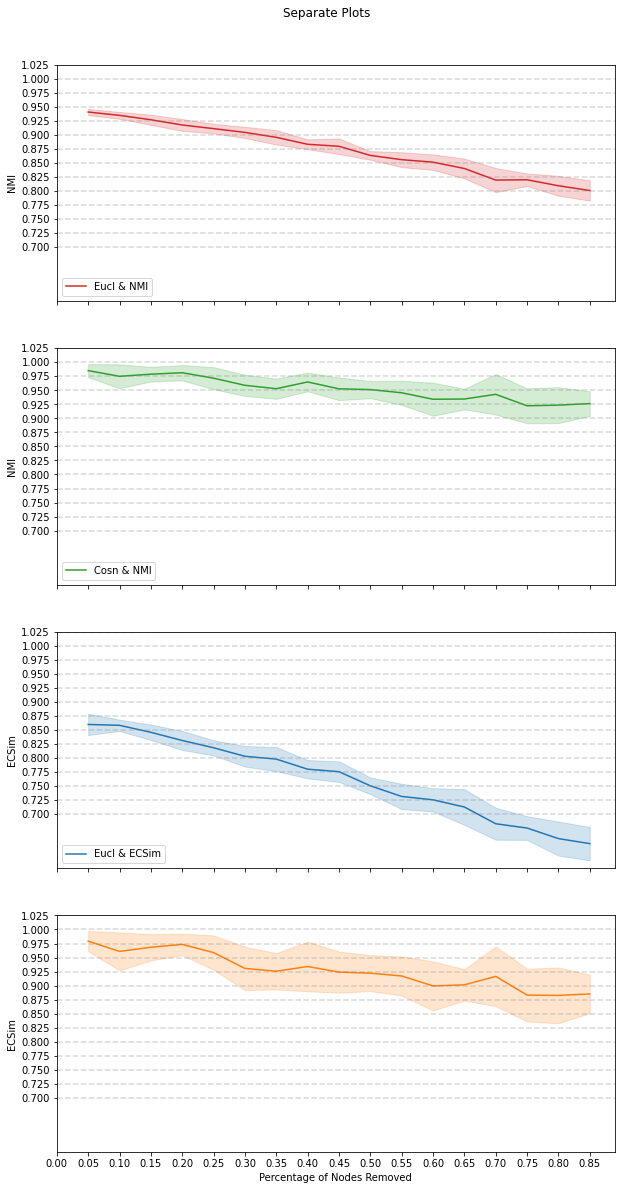

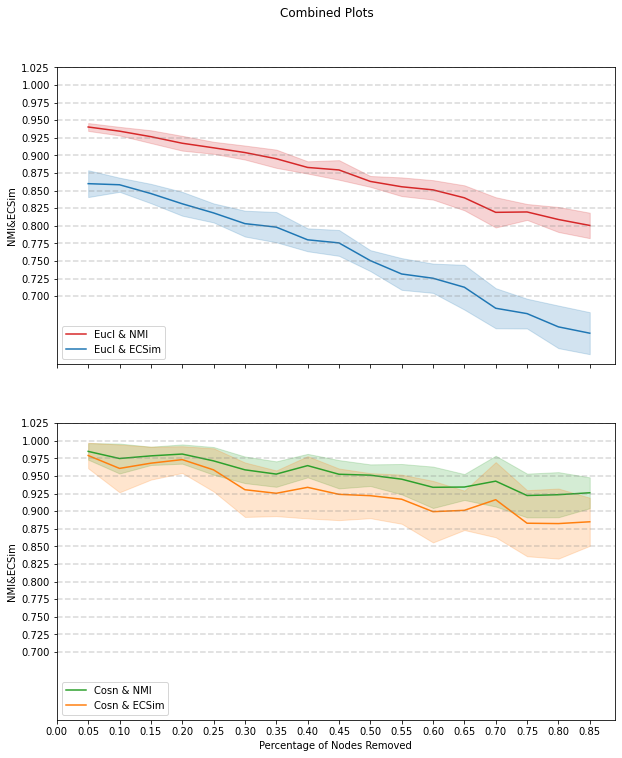

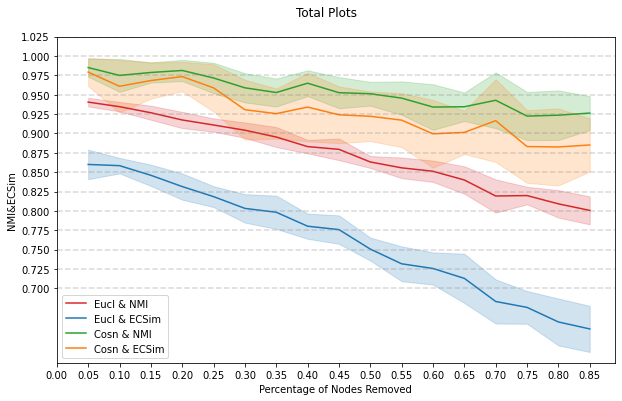

CPU times: user 3h 19min 50s, sys: 4h 14min 25s, total: 7h 34min 15s
Wall time: 6min 48s


In [15]:
%%time
Comprehensive_Processing(output=output_flag, random_disturb=random_disturb, method=1, num_cpus=num_cpus, graph = G, embedding_dimension=D, 
                        intrinsic_membership=intrinsic_membership, remove_procedure=remove_procedure, remove_procedure_index_form=index)

2LAP


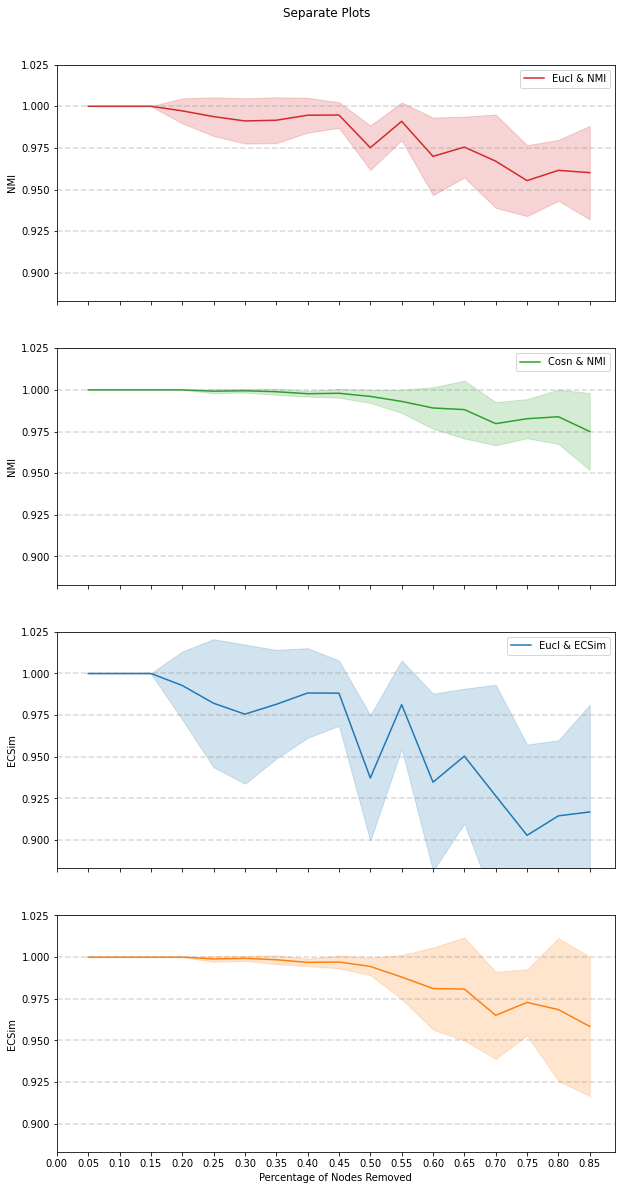

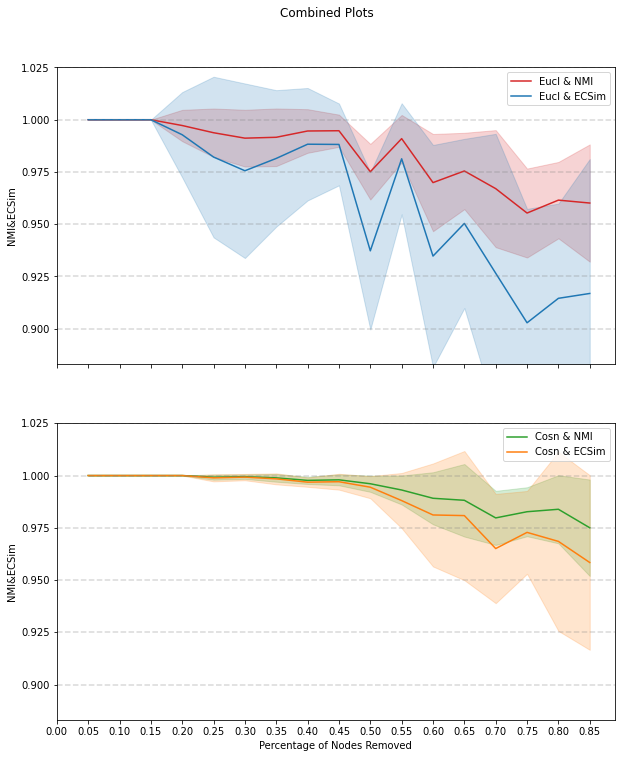

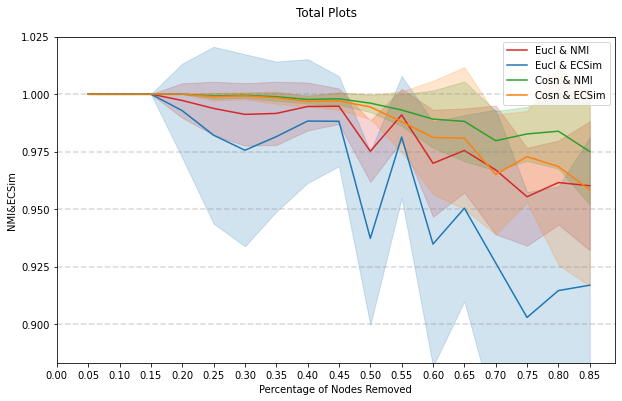

CPU times: user 2h 30min 38s, sys: 3h 37min 13s, total: 6h 7min 51s
Wall time: 5min 43s


In [16]:
%%time
Comprehensive_Processing(output=output_flag, random_disturb=random_disturb, method=2, num_cpus=num_cpus, graph = G, embedding_dimension=D, 
                         intrinsic_membership=intrinsic_membership, remove_procedure=remove_procedure, remove_procedure_index_form=index)

3LLE


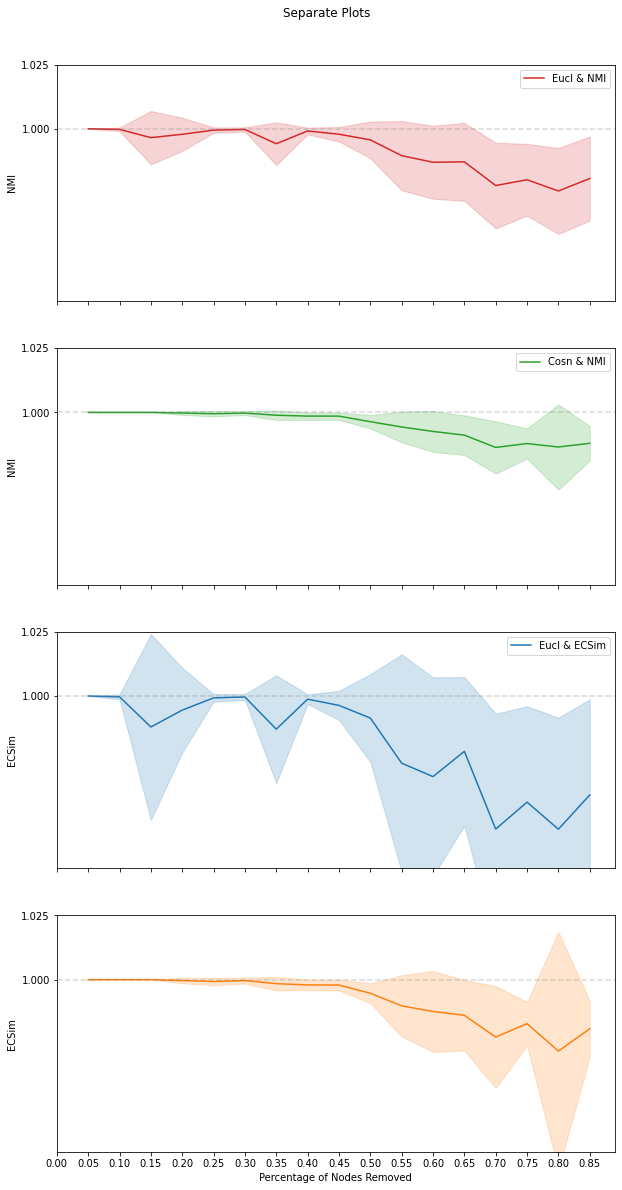

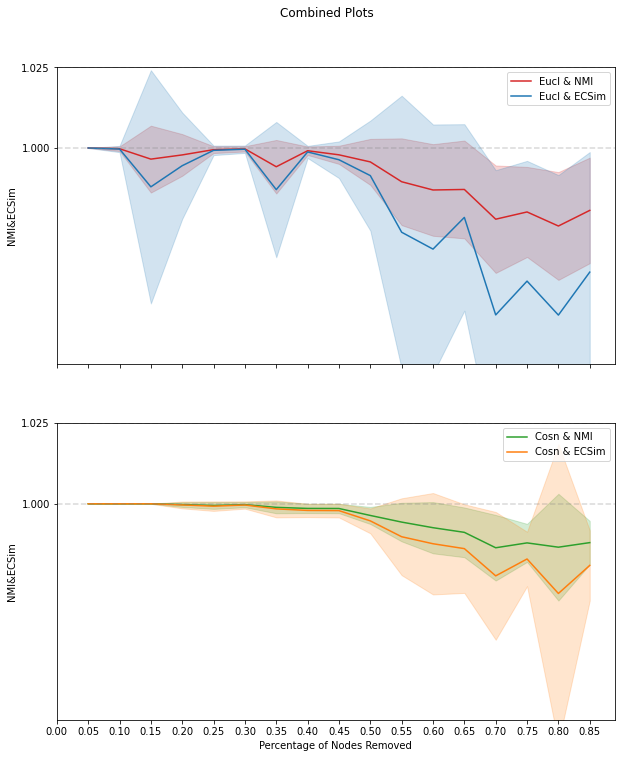

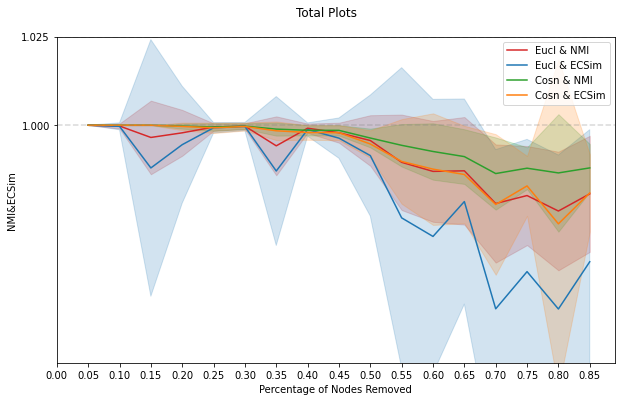

CPU times: user 2h 27min 25s, sys: 3h 41min 35s, total: 6h 9min
Wall time: 5min 18s


In [17]:
%%time
Comprehensive_Processing(output=output_flag, random_disturb=random_disturb, method=3, num_cpus=num_cpus, graph = G, embedding_dimension=D, 
                         intrinsic_membership=intrinsic_membership, remove_procedure=remove_procedure, remove_procedure_index_form=index)

4DeepWalk


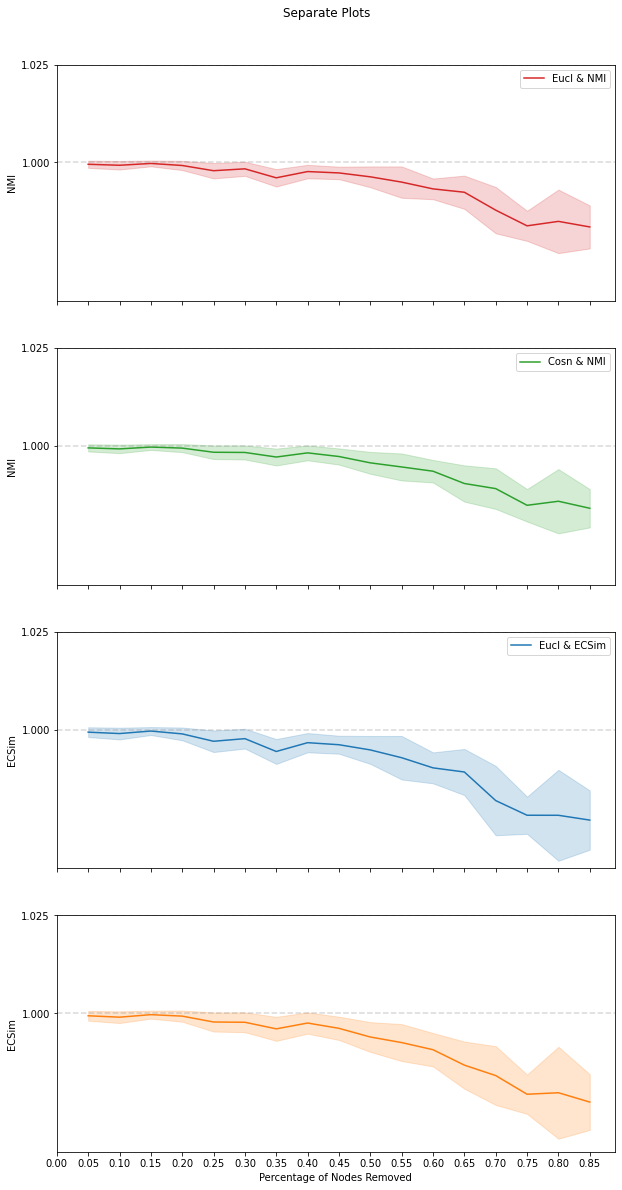

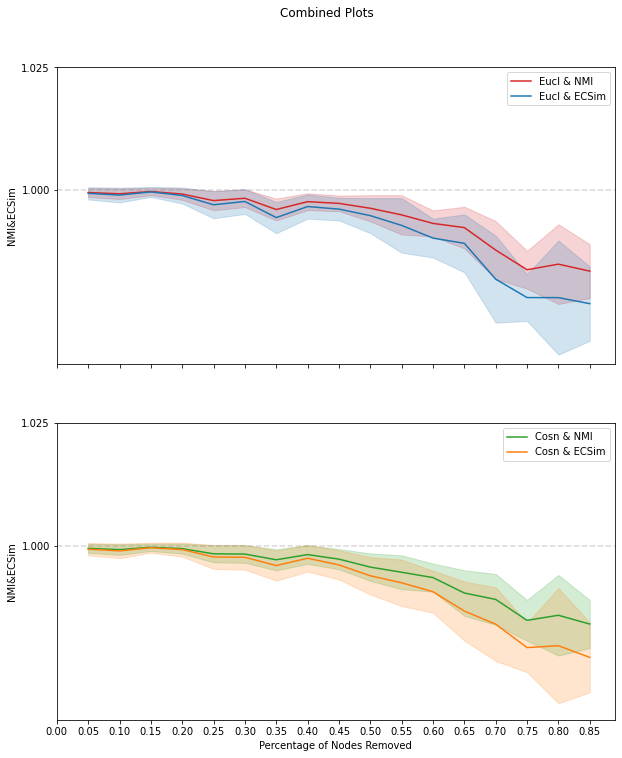

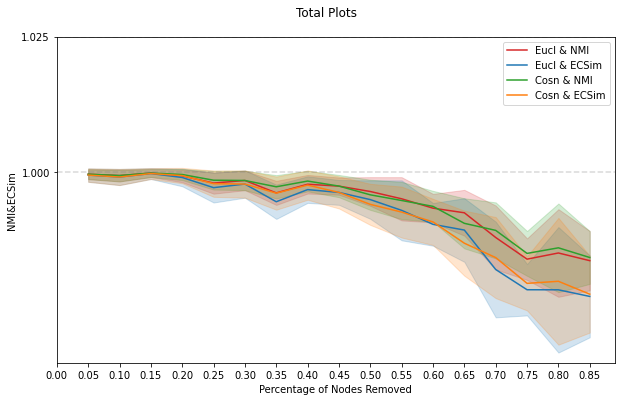

CPU times: user 2h 19min 29s, sys: 2h 50min 13s, total: 5h 9min 42s
Wall time: 5min 35s


In [18]:
%%time
Comprehensive_Processing(output=output_flag, random_disturb=random_disturb, method=4, num_cpus=num_cpus, graph = G, embedding_dimension=D, 
                         intrinsic_membership=intrinsic_membership, remove_procedure=remove_procedure, remove_procedure_index_form=index)

5MNMF


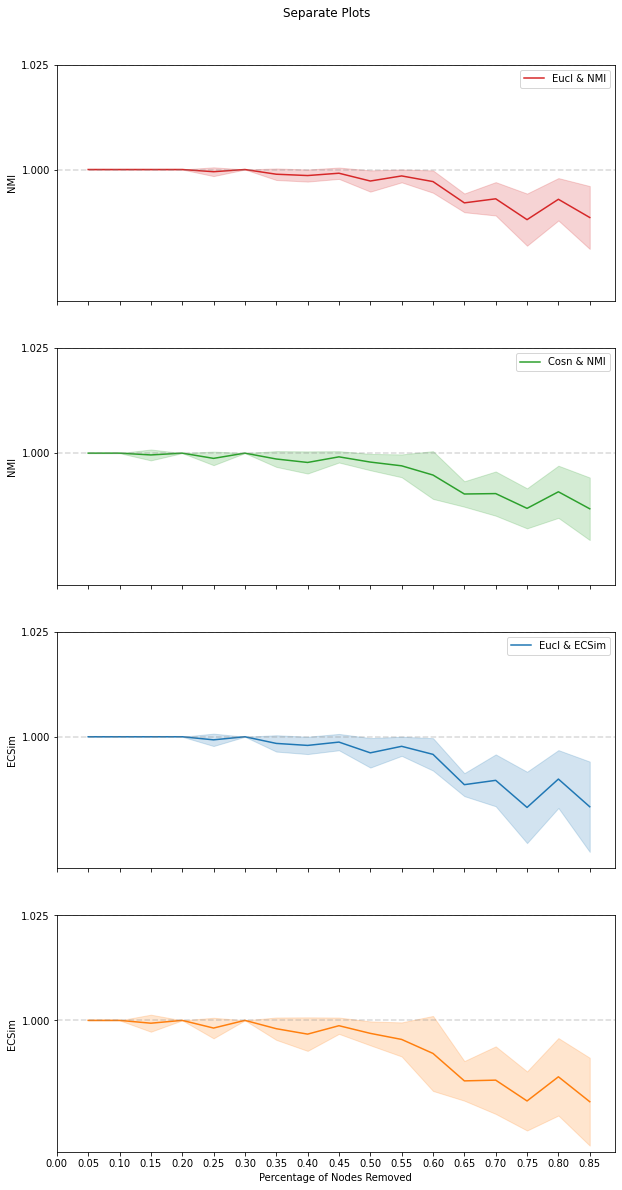

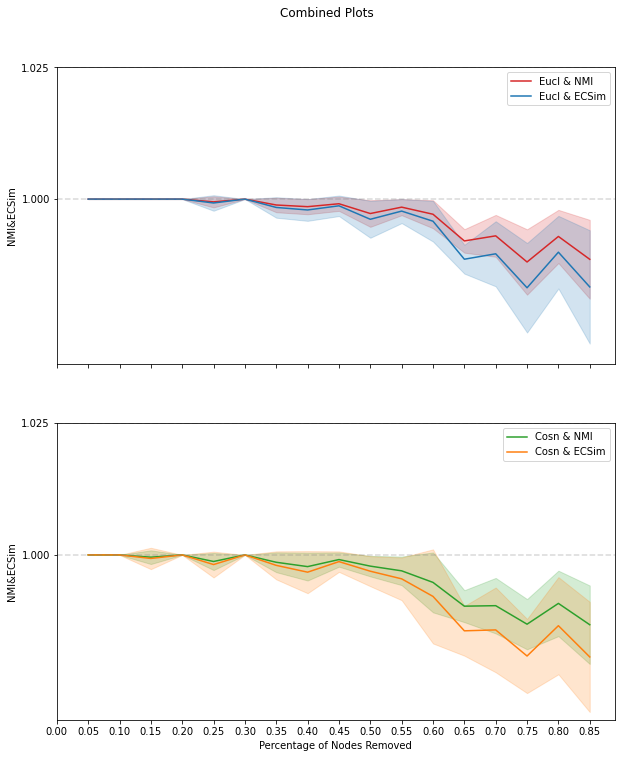

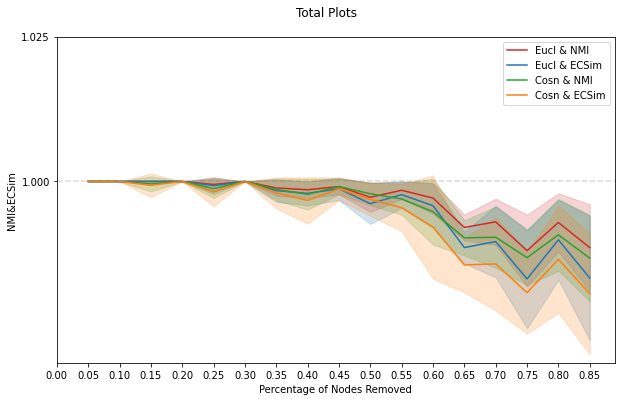

CPU times: user 2h 16min 18s, sys: 4h 26min 10s, total: 6h 42min 28s
Wall time: 6min 19s


In [19]:
%%time
Comprehensive_Processing(output=output_flag, random_disturb=random_disturb, method=5, num_cpus=num_cpus, graph = G, embedding_dimension=D, 
                         intrinsic_membership=intrinsic_membership, remove_procedure=remove_procedure, remove_procedure_index_form=index)

6LINE


2023-07-14 02:36:13.083375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 02:36:15.136866: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 731 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:02:00.0, compute capability: 8.0
2023-07-14 02:36:15.138188: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 37692 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2023-07-14 02:36:15.139223: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device

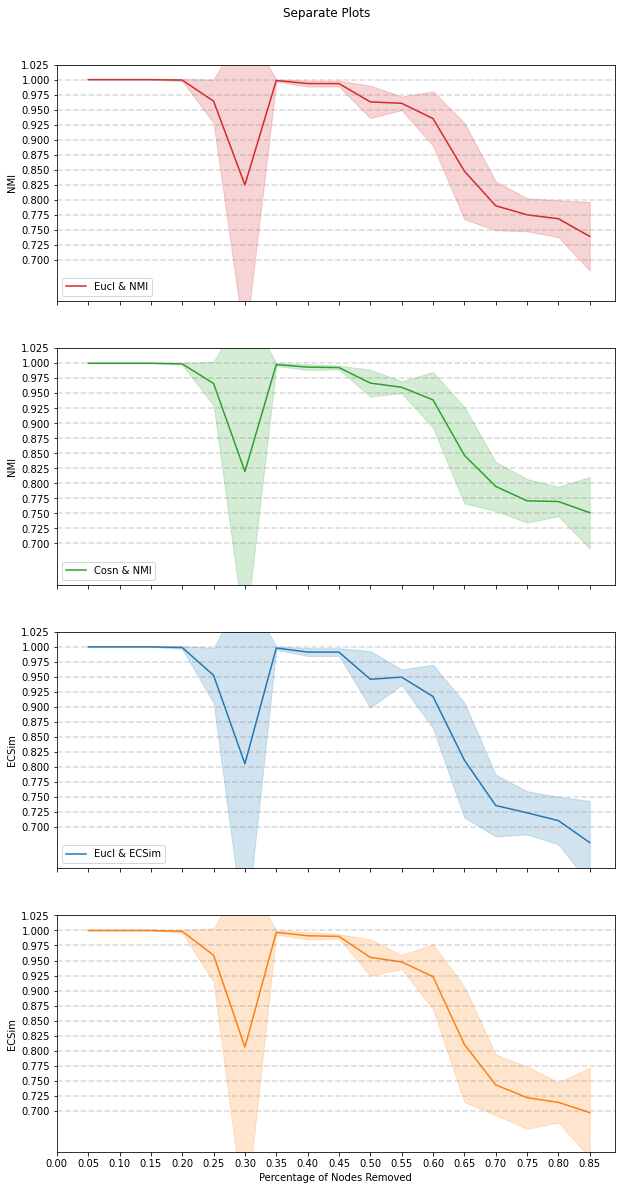

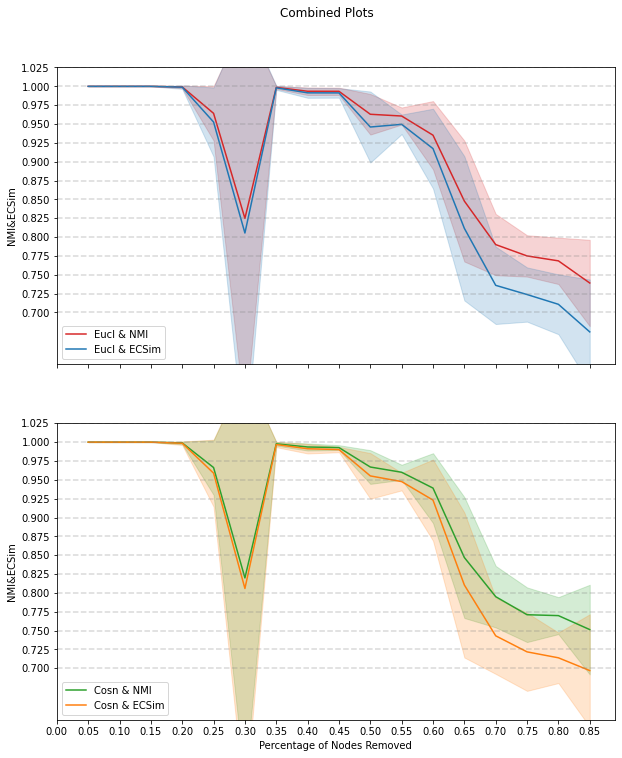

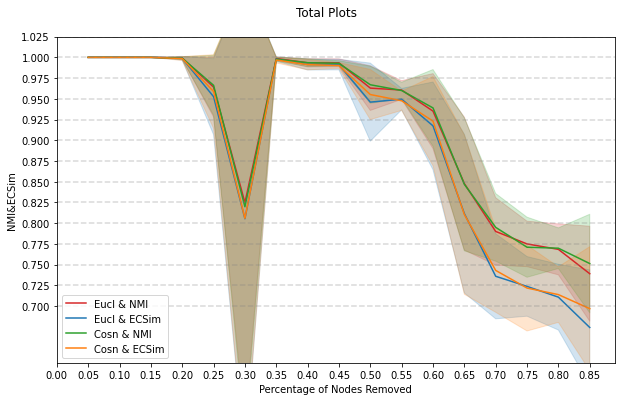

CPU times: user 1h 38min 6s, sys: 1h 35min 58s, total: 3h 14min 4s
Wall time: 8min 44s


In [20]:
%%time
Comprehensive_Processing(output=output_flag, random_disturb=random_disturb, method=6, num_cpus=num_cpus, graph = G, embedding_dimension=D, 
                         intrinsic_membership=intrinsic_membership, remove_procedure=remove_procedure, remove_procedure_index_form=index)

7Node2Vec


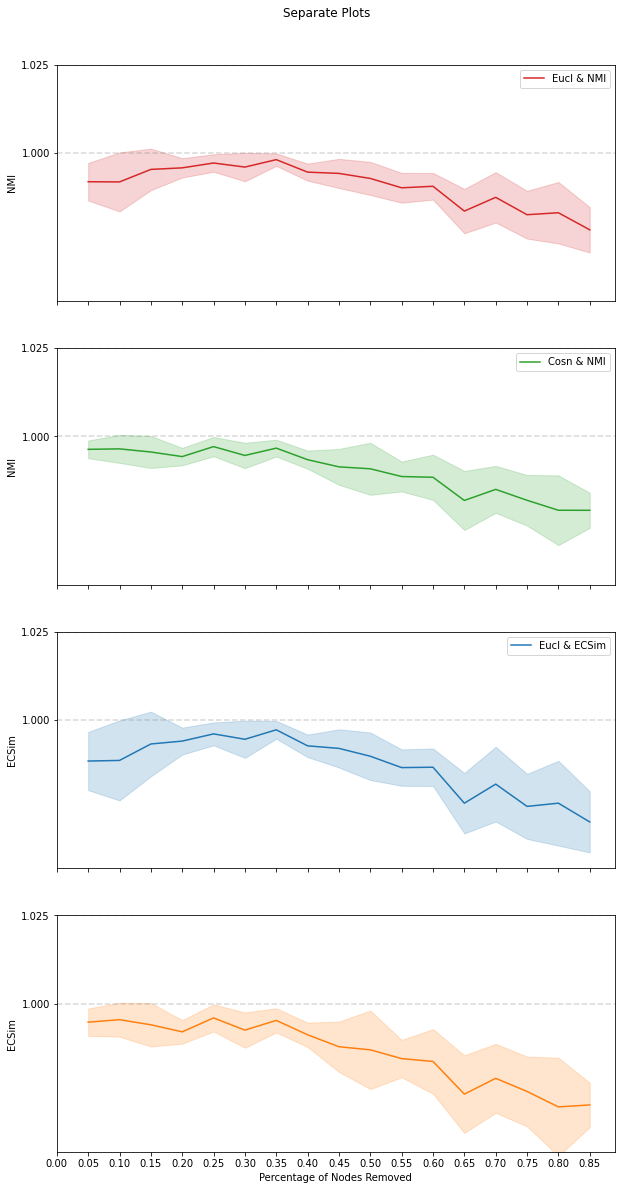

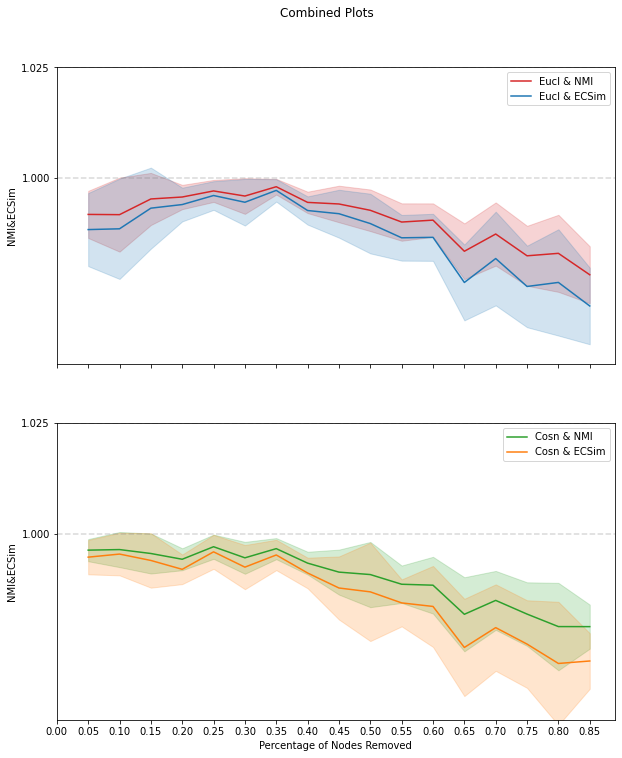

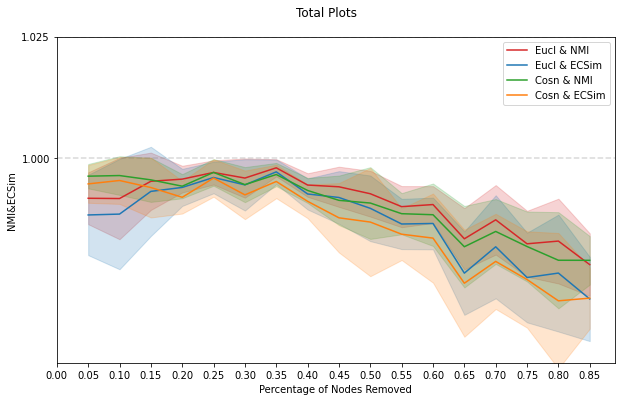

CPU times: user 1h 45min 32s, sys: 1h 42min 29s, total: 3h 28min 2s
Wall time: 7min 28s


In [21]:
%%time
Comprehensive_Processing(output=output_flag, random_disturb=random_disturb, method=7, num_cpus=num_cpus_n2v, graph = G, embedding_dimension=D, 
                         intrinsic_membership=intrinsic_membership, remove_procedure=remove_procedure, remove_procedure_index_form=index)

In [22]:
import networkx as nx

# Assuming you have a graph G

# Calculate betweenness centrality
betweenness_dict = nx.betweenness_centrality(G)

# Sort the dictionary by values in descending order
sorted_betweenness = dict(sorted(betweenness_dict.items(), key=lambda x: x[1], reverse=True))

# Print the sorted dictionary
for node, value in sorted_betweenness.items():
    print(f"Node: {node}, Betweenness Centrality: {value}")

Node: 917, Betweenness Centrality: 0.010761039325864323
Node: 297, Betweenness Centrality: 0.010194909454458593
Node: 393, Betweenness Centrality: 0.008784406433313355
Node: 360, Betweenness Centrality: 0.0084684243819742
Node: 652, Betweenness Centrality: 0.00844385534325672
Node: 21, Betweenness Centrality: 0.00842753403773572
Node: 62, Betweenness Centrality: 0.0083600977850385
Node: 352, Betweenness Centrality: 0.00831557882902515
Node: 39, Betweenness Centrality: 0.008305324957562317
Node: 235, Betweenness Centrality: 0.007889181581958716
Node: 821, Betweenness Centrality: 0.007867022226069284
Node: 979, Betweenness Centrality: 0.007847373538327589
Node: 182, Betweenness Centrality: 0.00778212116253036
Node: 495, Betweenness Centrality: 0.00769928521213503
Node: 210, Betweenness Centrality: 0.007563664319696248
Node: 57, Betweenness Centrality: 0.007461636499242675
Node: 892, Betweenness Centrality: 0.007411027401749747
Node: 975, Betweenness Centrality: 0.007208363635588359
Node: